# Particle transport in viscous streaming flows in frequency domain

In this notebook, we seek to solve for viscous streaming in the frequency domain.

In [1]:
using Pkg

In [2]:
pkg"update"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %  Updating git-repo `https://github.com/jdeldre/ViscousFlow.jl.git`
Fetching: [========================================>]  100.0 %.0 %  Updating git-repo `https://github.com/jdeldre/ViscousStreaming.jl.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/JuliaProjects/ViscousStreaming/notebooks/Project.toml`
  [103da179] ~ ViscousFlow v0.1.9 #master (https://github.com/jdeldre/ViscousFlow.jl.git)
  [47fb7046] ~ ViscousStreaming v0.1.0 #master (https://github.com/jdeldre/ViscousStreaming.jl.git)
  Updating `~/JuliaProjects/ViscousStreaming/notebooks/Manifest.toml`
  [103da179] ~ ViscousFlow v0.1.9 #master (https://github.com/jdeldre/ViscousFlow.jl.git)
  [47fb7046] ~ ViscousStreaming v0.1.0 #master (https://github.com/jdeldre/ViscousStreami

In [3]:
using Plots

In [4]:
using ViscousStreaming

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/ViscousStreaming/UPKy8.ji for ViscousStreaming [47fb7046-13b0-40db-b6a6-74fa44cf0959]
└ @ Base loading.jl:1240
[ Info: Building and caching LGF table


In [5]:
Re = 40
ϵ = 0.1
Ω = 1.0 # frequency (keep this equal to 1)
Tp = 2π/Ω # one period of oscillation

6.283185307179586

### Set up analytical solution

For the purposes of validation, we will set up the exact solution for a single oscillating cylinder.

In [6]:
p = StreamingParams(ϵ,Re)

Streaming flow parameters with Re = 40.0, ϵ = 0.1


In [9]:
s = StreamingAnalytical(p)

Maximum residual on W₁ = 1.1368683772161603e-13
BC residual on Ψ₁(1) = 2.7755575615628914e-17
BC residual on dΨ₁(1) = 5.23691153334427e-16
Maximum residual on Ws₂ = 1.3073986337985843e-12
BC residual on Ψs₂(1) = 0.0
BC residual on dΨs₂(1) = 8.881784197001252e-16
Maximum residual on W₂ = 2.1179418493558537e-12
BC residual on Ψ₂(1) = 1.734723475976807e-17
BC residual on dΨ₂(1) = 0.0


Analytical streaming flow solution for
single cylinder with Re = 40.0, ϵ = 0.1


### Set up the basic system for numerical solution for a single cylinder

#### Set up the grid cell size and approximate dimensions

In [7]:
Δx = 0.02
xlim = (-5.98,5.98)
ylim = (-5.98,5.98)

(-5.98, 5.98)

#### Set up a body

In [8]:
n = 150
body = Circle(1.0,n)

Circular body with 150 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


#### Set up the solver.
This step takes the longest, because it is inverting the system of equations. Every other solution step is fast.

In [9]:
@time solver1 = FrequencyStreaming(Re,ϵ,Δx,xlim,ylim,body);

 98.248687 seconds (414.89 M allocations: 44.976 GiB, 10.51% gc time)


#### Apply the solver to a basic motion

In [15]:
amp = [1.0,0.0]; # amplitude of the x and y velocity components

In [16]:
soln = solver1(amp,body);

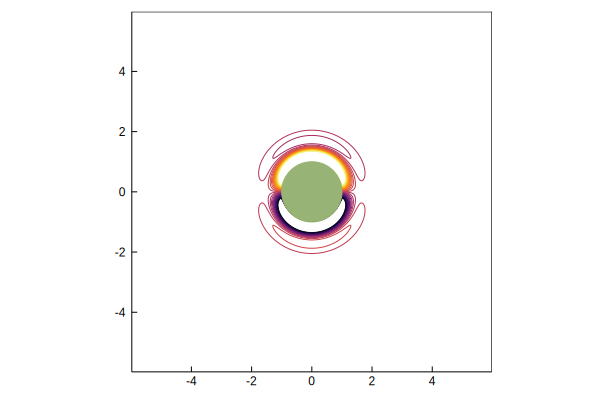

In [17]:
xg, yg = coordinates(soln.s1.W,solver1.grid)
plot(xg,yg,vorticity(0,soln.s1),levels=range(-2,2,length=30),clim=(-2,2),xlim=xlim,ylim=ylim)
plot!(body)

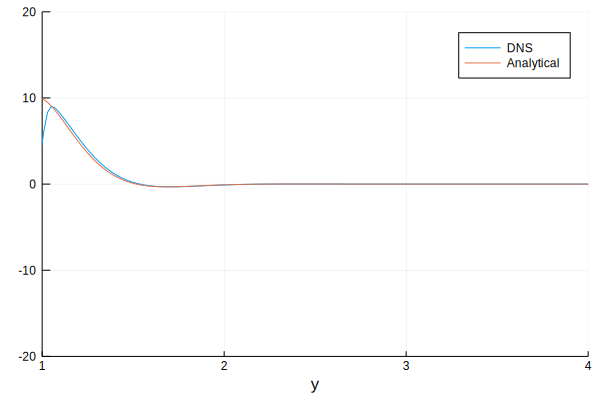

In [17]:
ix = 301
plot(yg,vorticity(0,soln.s1)[301,:],ylim=(-20,20),xlim=(1,4),label="DNS",xlabel="y")
plot!(yg,map(y -> vorticity(xg[ix],y,0.0,firstorder(s)),abs.(yg)),label="Analytical")

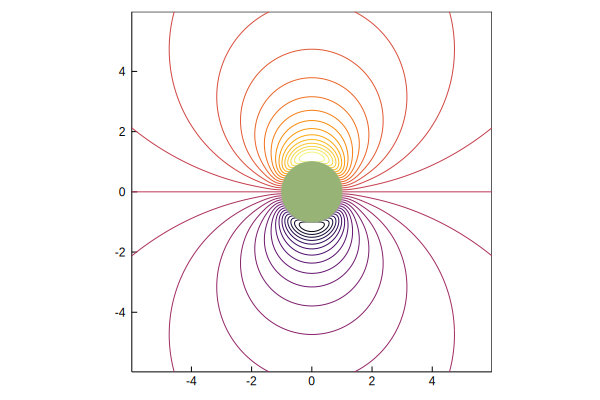

In [18]:
plot(xg,yg,streamfunction(0,soln.s1),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(body)

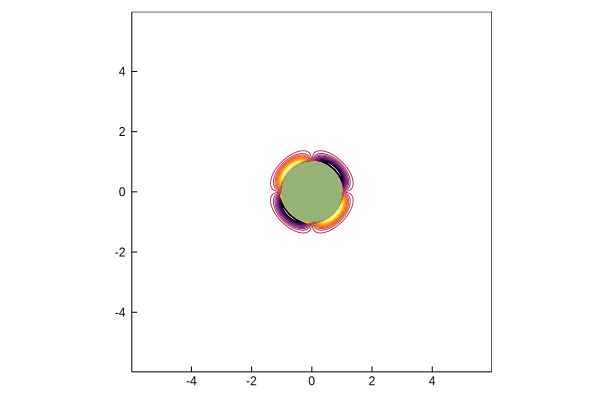

In [19]:
plot(xg,yg,vorticity(soln.s̄2),levels=range(-10,10,length=30),clim=(-10,10),xlim=xlim,ylim=ylim)
plot!(body)

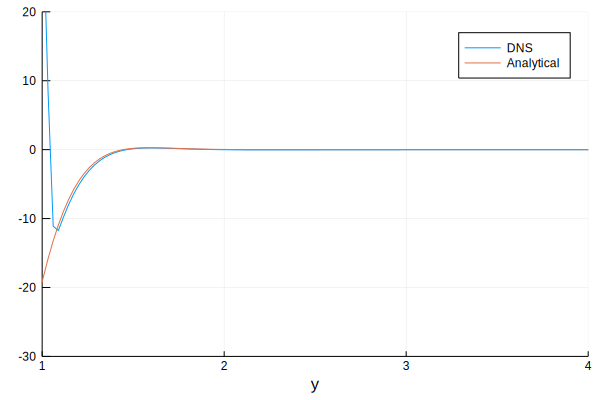

In [20]:
rg = sqrt.(xg.^2+yg.^2)
plot(rg,map(ix -> vorticity(soln.s̄2)[ix,ix],1:length(rg)),ylim=(-30,20),xlim=(1,4),label="DNS",xlabel="y")
plot!(rg,map(x -> vorticity(x,x,secondordermean(s)),xg),label="Analytical")

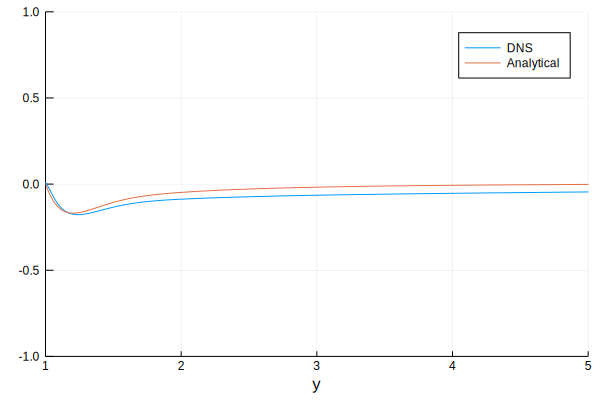

In [21]:
ig = 120
rg = sqrt.(xg[ig:end].^2+yg[ig:end].^2)
plot(rg,map(ix -> streamfunction(soln.s̄2)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(1,5),label="DNS",xlabel="y")
#plot!(rg,map(ix -> Δx*real(s22)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(0.5,2),label="DNS",xlabel="y")
plot!(rg,map(x -> streamfunction(x,x,secondordermean(s)),xg[ig:end]),label="Analytical")

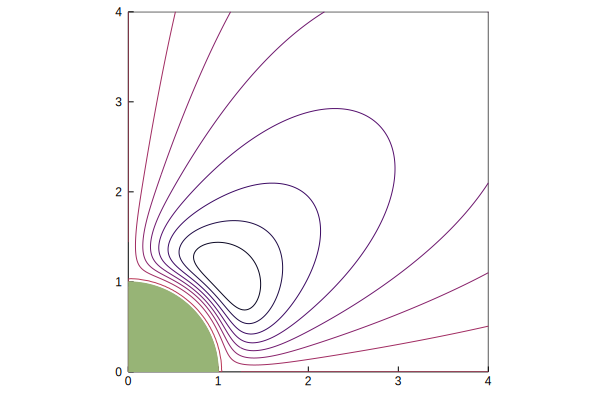

In [22]:
plot(xg,yg,lagrangian_mean_streamfunction(soln),levels=15,xlim=(0,4),ylim=(0,4))
plot!(body)

### Inertial particle transport for single cylinder

Here, we make use of the solver for a single cylinder to explore different cylinder motions and the resulting transport of inertial particles

#### First, set the particle parameters

In [10]:
τ = 0.1 # Stokes number, should be small
β = 0.95 # Density parameter. Less than 1 means heavier than fluid.

0.95

In [11]:
p_inert = InertialParameters(tau=τ,beta=β,epsilon=ϵ,Re=Re)

InertialParameters(0.95, 0.1, 0.1, 40)

#### Now generate the flow solution for a desired motion

Set the amplitude of the x and y velocity components. These can be complex, but should have magnitude on the order of 1.

In [12]:
amp = [1.0,0.0];

In [13]:
soln = solver1(amp,body);

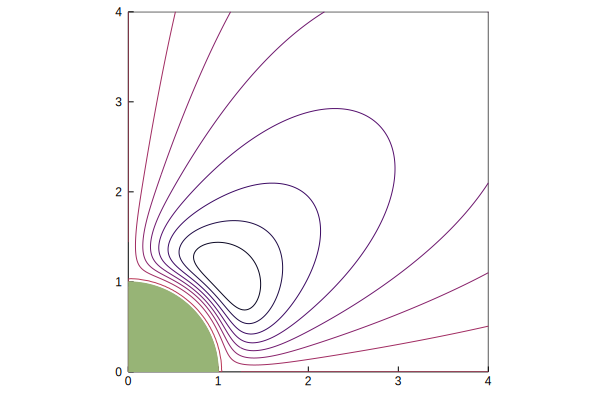

In [18]:
plot(xg,yg,lagrangian_mean_streamfunction(soln),levels=15,xlim=(0,4),ylim=(0,4))
plot!(body)

#### Get the inertial particle velocity field from the fluid velocity field

In [19]:
isoln = inertial_velocity(soln,p_inert);

#### Now construct the Lagrangian mean velocity field for the inertial particles

In [20]:
v̄L = lagrangian_mean_velocity(isoln);

#### For advancing particles, we need to construct an interpolatable version of v̄L

In [22]:
v̄Luxy, v̄Lvxy = interpolatable_field(v̄L,isoln.g);

#### Construct a right-hand side for advancing particles.

In [23]:
function mean_motion(dR,R,p,t,v̄Luxy,v̄Lvxy)
    dR[1] = v̄Luxy(R[1],R[2])
    dR[2] = v̄Lvxy(R[1],R[2])
    
   return dR 
end
v̄Lfcn(dR,R,p,t) = mean_motion(dR,R,p,t,v̄Luxy,v̄Lvxy)

v̄Lfcn (generic function with 1 method)

#### Now set initial particle location and the duration over which to integrate

In [24]:
X₀ = (3.0,3.8)
Tmax = 25000*Tp

157079.63267948964

In [25]:
solL = compute_trajectory(v̄Lfcn,X₀,Tmax,10Tp,body,ϵ=p.ϵ);

#### Plot the trajectory, along with the Lagrangian mean streamlines of the fluid flow

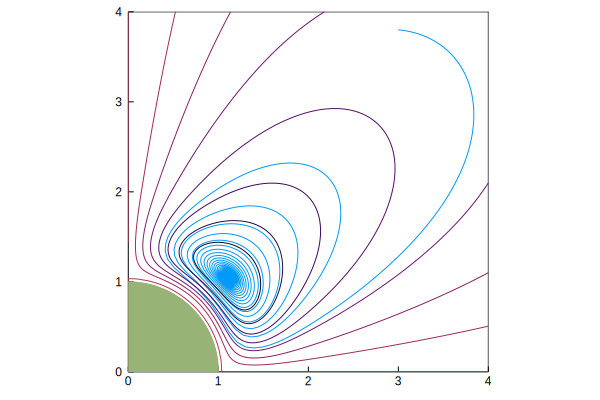

In [26]:
plot(solL[1,:],solL[2,:],ratio=1,legend=false,linewidth=1,xlim=(0,4),ylim=(0,4),label="Particle trajectory")
plot!(xg,yg,lagrangian_mean_streamfunction(soln),levels=15)
plot!(body)

### Now let's solve a problem with multiple bodies

In [27]:
bl = BodyList()

BodyList(Body[])

In [28]:
bL = deepcopy(body)
bR = deepcopy(body)

Circular body with 150 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [29]:
# left cylinder
cent = (-3.0,0.0)
α = 0.0
TL = RigidTransform(cent,α)
TL(bL) # transform the body to the current configuration

# right cylinder
cent = (3.0,0.0)
α = 0.0
TR = RigidTransform(cent,α)
TR(bR) # transform the body to the current configuration

push!(bl,bL)
push!(bl,bR)

2-element Array{Body,1}:
 Circular body with 150 points and radius 1.0
   Current position: (-3.0,0.0)
   Current angle (rad): 0.0

 Circular body with 150 points and radius 1.0
   Current position: (3.0,0.0)
   Current angle (rad): 0.0
 

#### Set up the system

In [30]:
@time solver2 = FrequencyStreaming(Re,ϵ,Δx,xlim,ylim,bl);

193.536207 seconds (1.47 G allocations: 103.491 GiB, 15.40% gc time)


#### Solve the system

In [31]:
ampvec = [[0.0,0.0] for i in 1:length(bl)];
ampvec[2][1] = 1.0;   # Set the amplitude of the x component of the right cylinder to 1

In [32]:
soln = solver2(ampvec,bl);

First-order vorticity at t = 0

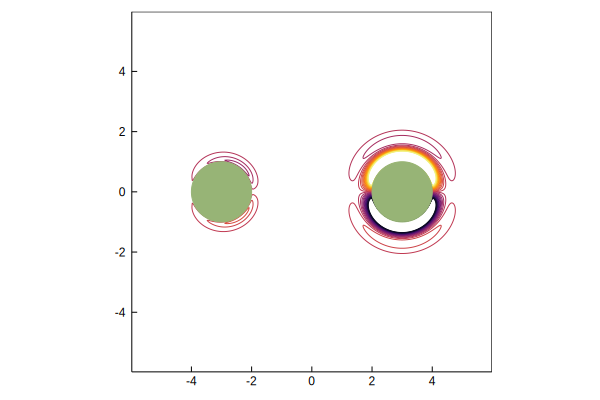

In [33]:
xg, yg = coordinates(soln.s1.W,soln.g)
plot(xg,yg,vorticity(0,soln.s1),levels=range(-2,2,length=30),clim=(-2,2),xlim=xlim,ylim=ylim)
plot!(bl)

First-order streamfunction at t = 0

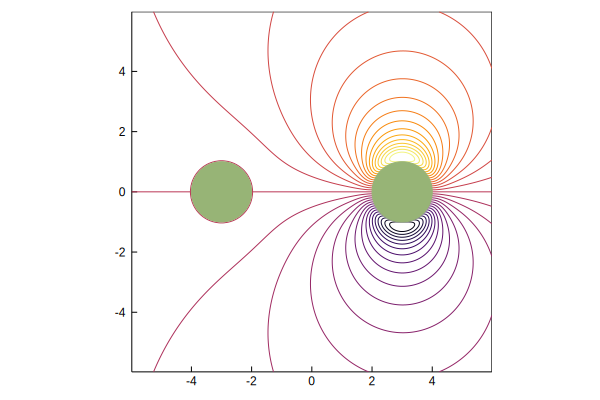

In [34]:
plot(xg,yg,streamfunction(0,soln.s1),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(bl)

Second-order mean vorticity

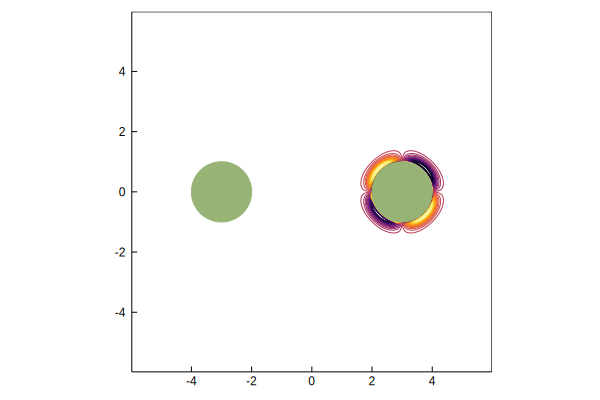

In [35]:
plot(xg,yg,vorticity(soln.s̄2),levels=range(-10,10,length=30),clim=(-10,10),xlim=xlim,ylim=ylim)
plot!(bl)

Lagrangian mean streamfunction

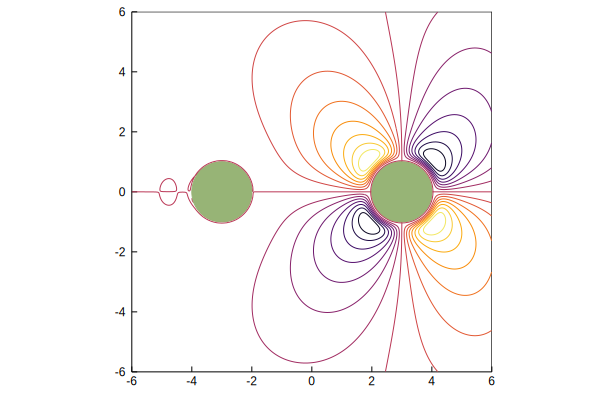

In [36]:
plot(xg,yg,lagrangian_mean_streamfunction(soln),levels=15,xlim=(-6,6),ylim=(-6,6))
plot!(bl)

### Inertial particle transport in two-cylinder problem

In [42]:
τ = 0.1 # Stokes number, should be small
β = 0.95 # Density parameter. Less than 1 means heavier than fluid.

0.95

In [43]:
p_inert = InertialParameters(tau=τ,beta=β,epsilon=ϵ,Re=Re)

InertialParameters(0.95, 0.1, 0.1, 40)

Set the body motion. For the sake of demonstration, we set their motions to be in the same direction but out of phase

In [44]:
ampvec = [ComplexF64[0.0,0.0] for i in 1:length(bl)];
ampvec[2][1] = 1.0;   # Set the amplitude of the x component of the right cylinder to 1
ampvec[1][1] = exp(im*π/2);

In [45]:
soln = solver2(ampvec,bl);

Inspect the Lagrangian mean streamlines of the fluid flow

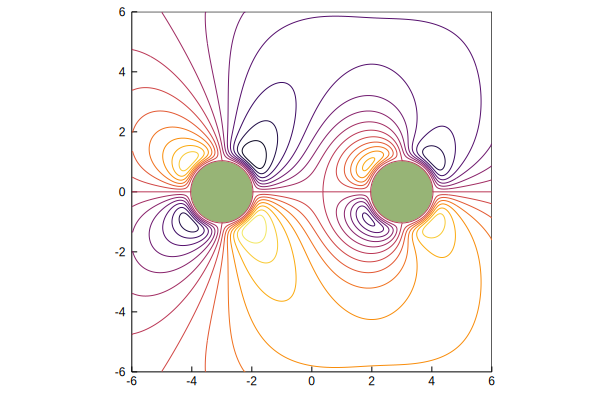

In [46]:
plot(xg,yg,lagrangian_mean_streamfunction(soln),levels=15,xlim=(-6,6),ylim=(-6,6))
plot!(bl)

Get the inertial particle velocity field from the fluid velocity field, using these particle parameters

In [47]:
isoln = inertial_velocity(soln,p_inert);

Now construct the Lagrangian mean velocity field for the inertial particles

In [48]:
v̄L = lagrangian_mean_velocity(isoln);

For advancing particles, we need to construct an interpolatable version of v̄L

In [50]:
v̄Luxy, v̄Lvxy = interpolatable_field(v̄L,isoln.g);

Construct a right-hand side for advancing particles.

In [51]:
v̄Lfcn(dR,R,p,t) = mean_motion(dR,R,p,t,v̄Luxy,v̄Lvxy)

v̄Lfcn (generic function with 1 method)

In [52]:
X₀ = (3.5,4.0)
Ω = 1.0
Tp = 2π/Ω
Tmax = 125000*Tp

785398.1633974483

In [53]:
solL = compute_trajectory(v̄Lfcn,X₀,Tmax,10Tp,bl=bl,ϵ=p.ϵ);

#### Plot the trajectory, along with the Lagrangian mean streamlines of the fluid flow

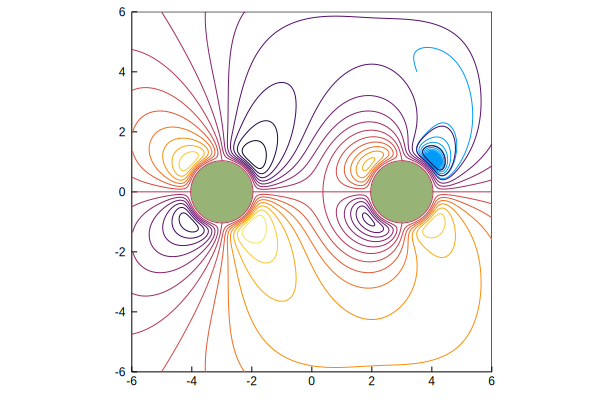

In [54]:
plot(solL[1,:],solL[2,:],ratio=1,legend=false,linewidth=1,xlim=(-6,6),ylim=(-6,6))
plot!(xg,yg,lagrangian_mean_streamfunction(soln),levels=15)
plot!(bl)

### Now multiple smaller bodies

Here, we will keep Re = 40, but effectively lower the Reynolds number by using smaller bodies. This should move the trapping points away from the bodies, thereby reducing the need for accuracy near them.

In [55]:
bl = BodyList()

BodyList(Body[])

In [56]:
n = 30
smallbody = Circle(0.2,n)

Circular body with 30 points and radius 0.2
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [57]:
b11 = deepcopy(smallbody)
b12 = deepcopy(smallbody)
b21 = deepcopy(smallbody)
b22 = deepcopy(smallbody)
b00 = deepcopy(smallbody)

Circular body with 30 points and radius 0.2
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [58]:
α = 0.0

# left lower cylinder
cent = (-3.0,-3.0)
T11 = RigidTransform(cent,α)
T11(b11) # transform the body to the current configuration

# right lower cylinder
cent = (3.0,-3.0)
α = 0.0
T12 = RigidTransform(cent,α)
T12(b12) # transform the body to the current configuration

# left upper cylinder
cent = (-3.0,3.0)
T21 = RigidTransform(cent,α)
T21(b21) # transform the body to the current configuration

# right upper cylinder
cent = (3.0,3.0)
α = 0.0
T22 = RigidTransform(cent,α)
T22(b22) # transform the body to the current configuration

# middle cylinder
cent = (0.0,0.0)
α = 0.0
T00 = RigidTransform(cent,α)
T00(b00) # transform the body to the current configuration


push!(bl,b11)
push!(bl,b12)
push!(bl,b21)
push!(bl,b22)
push!(bl,b00)

5-element Array{Body,1}:
 Circular body with 30 points and radius 0.2
   Current position: (-3.0,-3.0)
   Current angle (rad): 0.0

 Circular body with 30 points and radius 0.2
   Current position: (3.0,-3.0)
   Current angle (rad): 0.0
 
 Circular body with 30 points and radius 0.2
   Current position: (-3.0,3.0)
   Current angle (rad): 0.0
 
 Circular body with 30 points and radius 0.2
   Current position: (3.0,3.0)
   Current angle (rad): 0.0
  
 Circular body with 30 points and radius 0.2
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
  

#### Set up the system

In [59]:
@time solver5 = FrequencyStreaming(Re,ϵ,Δx,xlim,ylim,bl);

 85.820629 seconds (364.59 M allocations: 42.517 GiB, 14.66% gc time)


#### Inertial particle transport

In [60]:
τ = 0.1 # Stokes number, should be small
β = 0.95 # Density parameter. Less than 1 means heavier than fluid.

0.95

In [61]:
p_inert = InertialParameters(tau=τ,beta=β,epsilon=ϵ,Re=Re)

InertialParameters(0.95, 0.1, 0.1, 40)

Here, we just play around, setting every amplitude component

In [62]:
ampvec = [ComplexF64[0.0,0.0] for i in 1:length(bl)];
fill!.(ampvec,1)
ampvec[4] = [1.5,1.5]
fsoln = solver5(ampvec,bl);

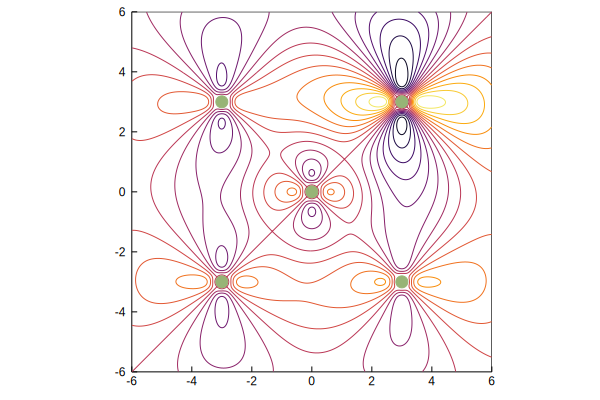

In [63]:
xg, yg = coordinates(soln.s1.W,soln.g)
plot(xg,yg,lagrangian_mean_streamfunction(fsoln),levels=15,xlim=(-6,6),ylim=(-6,6))
plot!(bl)

Below, we precompute the flow solutions and interpolatable Lagrangian mean particle velocities for every individual motion 

In [64]:
v̄Luvec = typeof(v̄Luxy)[]
v̄Lvvec = typeof(v̄Lvxy)[]
fsolnvec = StreamingComputational{ViscousStreaming.FluidFlow}[]
for i in 1:10
    ampvec = zero.(ampvec)
    ampvec[floor(Int,(i+1)/2)][2-mod(i,2)] = 1.0
    push!(fsolnvec,solver5(ampvec,bl))
    isoln = inertial_velocity(fsolnvec[i],p_inert)
    v̄L = lagrangian_mean_velocity(isoln)
    v̄Luxy, v̄Lvxy = interpolatable_field(v̄L, isoln.g)
    push!(v̄Luvec,v̄Luxy)
    push!(v̄Lvvec,v̄Lvxy)
end

Plot the individual streaming flows for each motion primitive

In [65]:
imotion = 5
xg, yg = coordinates(soln.s1.W,soln.g)
ps = []
for imotion in 1:10
    push!(ps,plot(xg,yg,lagrangian_mean_streamfunction(fsolnvec[imotion]),levels=15,xlim=(-6,6),ylim=(-6,6)))
    ps[end] = plot!(bl)
end
plot(ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10])

Plan: Need to create a function that accepts the frequency-based flow solver and a plan for how to apply a series of motion primitives. This plan should be a function of time, and the output of this plan should be a specification of the U,V amplitudes of every body in the list. This would be passed to the solver to generate the fluid flow soln, and thence to the inertial_velocity for the inertial particle solution and lagrangian mean velocity.

The final result should be a callable function that returns the time-varying Lagrangian mean velocity, to be used by the compute_trajectory function.

Here, we set up a function that calls the appropriate interpolated field in the given time interval.

In [66]:
Tswitch = [0,35000Tp,105000Tp,140000Tp,175000Tp,210000Tp,Inf]
iswitch = [1,9,3,9,5,9]; # The motion primitive to call in each time interval

In [67]:
function motion_assembly(dR,R,p,t,v̄Luvec,v̄Lvvec,iswitch,Tswitch)
    index = findall(!iszero,diff(sign.(t .- Tswitch)))[1]
    v̄Lu, v̄Lv = v̄Luvec[iswitch[index]], v̄Lvvec[iswitch[index]]
    dR[1] = v̄Lu(R[1],R[2])
    dR[2] = v̄Lv(R[1],R[2])
    
   return dR 
end

motion_assembly (generic function with 1 method)

In [68]:
v̄Lfcn(dR,R,p,t) = motion_assembly(dR,R,p,t,v̄Luvec,v̄Lvvec,iswitch,Tswitch)

v̄Lfcn (generic function with 1 method)

In [69]:
X₀ = (-1.0,-1.0)
Ω = 1.0
Tp = 2π/Ω
Tmax = 220000*Tp

1.382300767579509e6

In [70]:
solL = compute_trajectory(v̄Lfcn,X₀,Tmax,10Tp,bl=bl,ϵ=p.ϵ);

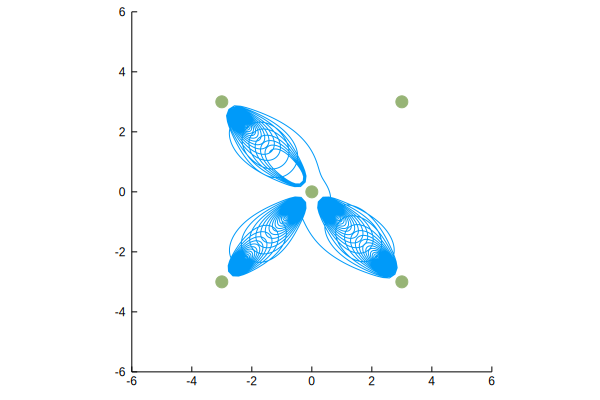

In [71]:
plot(solL[1,:],solL[2,:],ratio=1,legend=false,linewidth=1,xlim=(-6,6),ylim=(-6,6))
plot!(bl)